<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from mre import pytorch_unet_tb
from mre.prediction import MREDataset
from mre.plotting import torch_dl_vis
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import mre.prediction as pred


# Load mre data
full_data_dir = '/pghbio/dbmi/batmanlab/Data/MRE/'
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_3.p', 'rb'))

In [2]:
ds

<xarray.Dataset>
Dimensions:      (sequence: 10, subject: 48, x: 256, y: 256, z: 4)
Coordinates:
  * subject      (subject) <U3 '162' '163' '178' '189' ... '404' '405' '406'
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * y            (y) int64 0 -1 -2 -3 -4 -5 -6 ... -250 -251 -252 -253 -254 -255
  * z            (z) int64 0 1 2 3
Data variables:
    image        (subject, sequence, z, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    age          (subject) int8 -27 -91 -107 117 -123 ... -107 -107 5 -59 101
    z_space      (subject, sequence) float16 13.8 10.0 10.0 10.0 ... 0.0 0.0 0.0
    z_space_std  (subject) float16 1.684 3.826 6.656 1.6 ... 3.812 1.049 2.854

In [3]:
print(ds.sequence)
print(ds.subject[0])

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T1Pre', 'T1Pos', 'T2FR', 'T2SS', 'elast', 'elastMsk', 'msk',
       'liverMsk', 'extra2', 'extra3'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
<xarray.DataArray 'subject' ()>
array('162', dtype='<U3')
Coordinates:
    subject  <U3 '162'


In [4]:
# Use xArray to define the dataset.  Easy to query and map (although might not be fast when scaling up)
# input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos', 'T2FR']).image
input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos']).image
target_example = ds.sel(sequence=['elast']).image

In [5]:
input_example.values.shape

(48, 3, 4, 256, 256)

In [32]:
trans=True
clip=True

train_set = MREDataset(ds, set_type='train', transform = trans, clip=clip)
val_set = MREDataset(ds, set_type='val', transform = trans, clip=clip)
test_set = MREDataset(ds, set_type='test', transform = trans, clip=clip)

image_datasets = {
    'train': train_set, 'val': val_set, 'test':test_set
}

batch_size = 10

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 172, 'val': 18, 'test': 2}

torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
lol


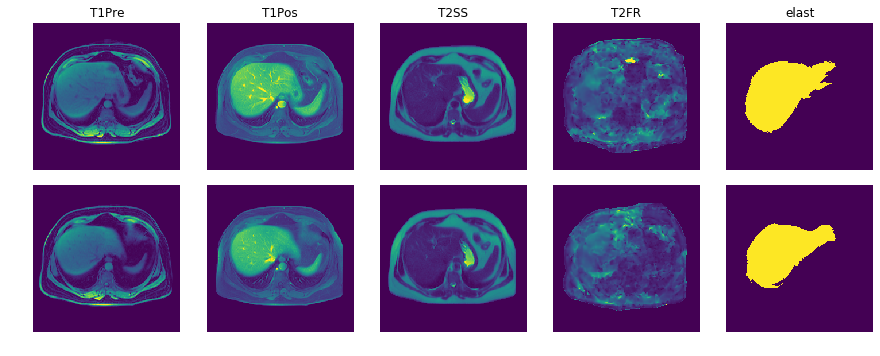

In [33]:
# Get a batch of training data
inputs, targets, masks= next(iter(dataloaders['test']))

#print(inputs.shape, masks.shape)
#for x in [inputs.numpy(), masks.numpy()]:
#    print(x.min(), x.max(), x.mean(), x.std())
print(inputs.shape)
print(targets.shape)

torch_dl_vis(inputs, targets, masks)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = pytorch_unet_tb.UNet(1)
model = model.to(device)

summary(model, input_size=(3, 256, 256))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 256, 256]             112
       BatchNorm2d-2          [-1, 4, 256, 256]               8
              ReLU-3          [-1, 4, 256, 256]               0
            Conv2d-4          [-1, 4, 256, 256]             148
       BatchNorm2d-5          [-1, 4, 256, 256]               8
              ReLU-6          [-1, 4, 256, 256]               0
         MaxPool2d-7          [-1, 4, 128, 128]               0
            Conv2d-8          [-1, 8, 128, 128]             296
       BatchNorm2d-9          [-1, 8, 128, 128]              16
             ReLU-10          [-1, 8, 128, 128]               0
           Conv2d-11          [-1, 8, 128, 128]             584
      BatchNorm2d-12          [-1, 8, 128, 128]              16
             ReLU-13          [-1, 8, 128, 128]               0
        MaxPool2d-14            [-

In [35]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

'2019-05-07_12-13-55'

In [42]:
from datetime import datetime
now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = pytorch_unet_tb.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=5e-2)

exp_lr_scheduler = pred.lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

#writer = SummaryWriter('runs/baseline')
#writer = SummaryWriter('runs/clip_0')
#writer = SummaryWriter('runs/clip_norm_0')
#writer = SummaryWriter('runs/norm_redcap_0')
writer = SummaryWriter('runs/'+now)
model = pred.train_model(model, optimizer_ft, exp_lr_scheduler, device, dataloaders, num_epochs=40, tb_writer=writer)
#writer.export_scalars_to_json("./all_scalars.json")
writer.close()




cuda:0
Epoch 0/39
----------
LR 0.05
train: loss: 15036056.883721
val: loss: 10775541.888889
saving best model
0m 2s
Epoch 1/39
----------
LR 0.05
train: loss: 14945121.372093
val: loss: 13188622.111111
0m 2s
Epoch 2/39
----------
LR 0.05
train: loss: 14625210.930233
val: loss: 12444094.555556
0m 2s
Epoch 3/39
----------
LR 0.05
train: loss: 13948939.709302
val: loss: 10522127.000000
saving best model
0m 2s
Epoch 4/39
----------
LR 0.05
train: loss: 12964127.476744
val: loss: 5505996.055556
saving best model
0m 2s
Epoch 5/39
----------
LR 0.05
train: loss: 11595184.220930
val: loss: 6131658.666667
0m 2s
Epoch 6/39
----------
LR 0.05
train: loss: 10208322.802326
val: loss: 5907456.388889
0m 2s
Epoch 7/39
----------
LR 0.05
train: loss: 8724384.947674
val: loss: 3665780.777778
saving best model
0m 2s
Epoch 8/39
----------
LR 0.05
train: loss: 7293727.037791
val: loss: 4085487.555556
0m 2s
Epoch 9/39
----------
LR 0.05
train: loss: 6034635.869186
val: loss: 5689496.722222
0m 2s
Epoch 10/3

In [45]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_loader =  DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels, masks = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

model_pred = model(inputs)

model_pred_np = model_pred.data.cpu().numpy()
labels = labels.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()
masks = masks.data.cpu().numpy()
print(inputs.shape)

# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

(1, 3, 256, 256)


True ave Stiffness: 2285.7786
Predicted ave Stiffness: 1504.5818


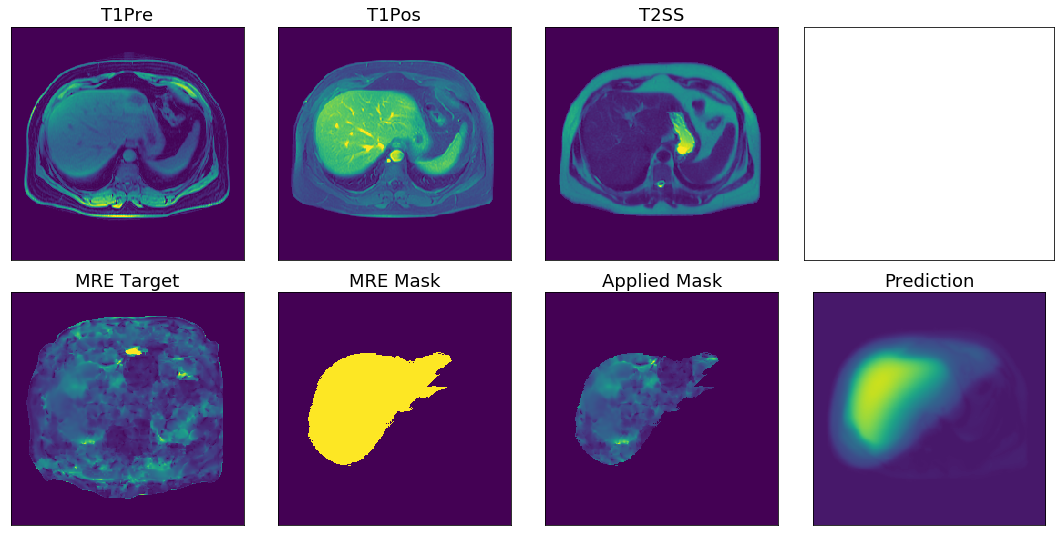

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(3.75*4, 3.75*2),
                             sharex=True, sharey=True,)
axs[0][0].imshow(inputs[0][0])
axs[0][0].set_title('T1Pre', size=18)

axs[0][1].imshow(inputs[0][1])
axs[0][1].set_title('T1Pos', size=18)
axs[0][2].imshow(inputs[0][2])
axs[0][2].set_title('T2SS', size=18)
#axs[0][3].imshow(inputs[0][3])
#axs[0][3].set_title('T2FR', size=18)
target = labels[0][0]
mask = masks[0][0]
prediction = model_pred_np[0][0]
target_mask = target*mask
prediction_mask = prediction*mask

axs[1][0].imshow(target)
axs[1][0].set_title('MRE Target', size=18)
axs[1][1].imshow(mask)
axs[1][1].set_title('MRE Mask', size=18)
axs[1][2].imshow(target_mask, vmin=target_mask.min(), vmax=target_mask.max())
axs[1][2].set_title('Applied Mask', size=18)
axs[1][3].imshow(prediction, vmin=target_mask.min(), vmax=target_mask.max())
axs[1][3].set_title('Prediction', size=18)

plt.xticks([])
plt.yticks([])

fig.tight_layout()
#plt.savefig('../plots/prediction.png')
#plt.savefig('../plots/prediction.pdf')
print('True ave Stiffness:', np.nanmean(np.where(target_mask>0, target_mask, np.nan)))
print('Predicted ave Stiffness:', np.nanmean(np.where(prediction>0, prediction, np.nan)))